<a href="https://colab.research.google.com/github/nooh1318/fire/blob/main/fireweek4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Dataset downloaded at: /kaggle/input/the-wildfire-dataset
⚠️ GPU not available.
Classes found: ['nofire', 'fire']
Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
15/59 ━━━━━━━━━━━━━━━━━━━━ 12:33 17s/step - accuracy: 0.5958 - loss: 0.7153

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


23/59 ━━━━━━━━━━━━━━━━━━━━ 10:26 17s/step - accuracy: 0.6109 - loss: 0.6969

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6568 - loss: 0.6337 
Epoch 1: val_accuracy improved from -inf to 0.61194, saving model to wildfire_model_20250504-062422.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1254s 20s/step - accuracy: 0.6578 - loss: 0.6324 - val_accuracy: 0.6119 - val_loss: 0.6899 - learning_rate: 1.0000e-04
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8280 - loss: 0.3996 
Epoch 2: val_accuracy did not improve from 0.61194
59/59 ━━━━━━━━━━━━━━━━━━━━ 1130s 19s/step - accuracy: 0.8282 - loss: 0.3991 - val_accuracy: 0.6119 - val_loss: 0.6827 - learning_rate: 1.0000e-04
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8750 - loss: 0.3088 
Epoch 3: val_accuracy did not improve from 0.61194
59/59 ━━━━━━━━━━━━━━━━━━━━ 1137s 19s/step - accuracy: 0.8752 - loss: 0.3083 - val_accuracy: 0.4826 - val_loss: 0.7072 - learning_rate: 1.0000e-04
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9022 - loss: 0.2478 
Epoch 4: val_accuracy did not improve from 0.61194
59/59 ━━━━━━━━━━━━━━━━━━━━ 1126s 19s/step - accuracy: 0.9022 - loss: 0.2475 - val_accuracy: 0.4900 - val_loss: 0.7051 - learning_rate: 1.0000e-04
Epoch 5/

59/59 ━━━━━━━━━━━━━━━━━━━━ 1163s 20s/step - accuracy: 0.9435 - loss: 0.1401 - val_accuracy: 0.6915 - val_loss: 0.6009 - learning_rate: 2.0000e-05
Epoch 9/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9415 - loss: 0.1456 
Epoch 9: val_accuracy did not improve from 0.69154
59/59 ━━━━━━━━━━━━━━━━━━━━ 1209s 19s/step - accuracy: 0.9415 - loss: 0.1458 - val_accuracy: 0.6891 - val_loss: 0.6750 - learning_rate: 2.0000e-05
Epoch 10/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9431 - loss: 0.1375 
Epoch 10: val_accuracy improved from 0.69154 to 0.78607, saving model to wildfire_model_20250504-062422.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1131s 19s/step - accuracy: 0.9430 - loss: 0.1375 - val_accuracy: 0.7861 - val_loss: 0.5088 - learning_rate: 2.0000e-05
Epoch 11/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9398 - loss: 0.1590 
Epoch 11: val_accuracy improved from 0.78607 to 0.80846, saving model to wildfire_model_20250504-062422.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1147s 19s/step - accuracy: 0.9398 - loss: 0.1588 - val_accuracy: 0.8085 - val_loss: 0.5355 - learning_rate: 2.0000e-05
Epoch 12/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9414 - loss: 0.1395 
Epoch 12: val_accuracy improved from 0.80846 to 0.82836, saving model to wildfire_model_20250504-062422.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1133s 19s/step - accuracy: 0.9415 - loss: 0.1394 - val_accuracy: 0.8284 - val_loss: 0.4828 - learning_rate: 2.0000e-05
Epoch 13/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9522 - loss: 0.1170 
Epoch 13: val_accuracy improved from 0.82836 to 0.83582, saving model to wildfire_model_20250504-062422.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1162s 20s/step - accuracy: 0.9522 - loss: 0.1170 - val_accuracy: 0.8358 - val_loss: 0.4839 - learning_rate: 2.0000e-05
Epoch 14/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9558 - loss: 0.1226 
Epoch 14: val_accuracy did not improve from 0.83582
59/59 ━━━━━━━━━━━━━━━━━━━━ 1195s 20s/step - accuracy: 0.9558 - loss: 0.1225 - val_accuracy: 0.6841 - val_loss: 1.1817 - learning_rate: 2.0000e-05
Epoch 15/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9584 - loss: 0.1219 
Epoch 15: val_accuracy did not improve from 0.83582

Epoch 15: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1248s 21s/step - accuracy: 0.9584 - loss: 0.1219 - val_accuracy: 0.7164 - val_loss: 0.9594 - learning_rate: 2.0000e-05


✅ Final model saved as 'final_wildfire_model.h5'


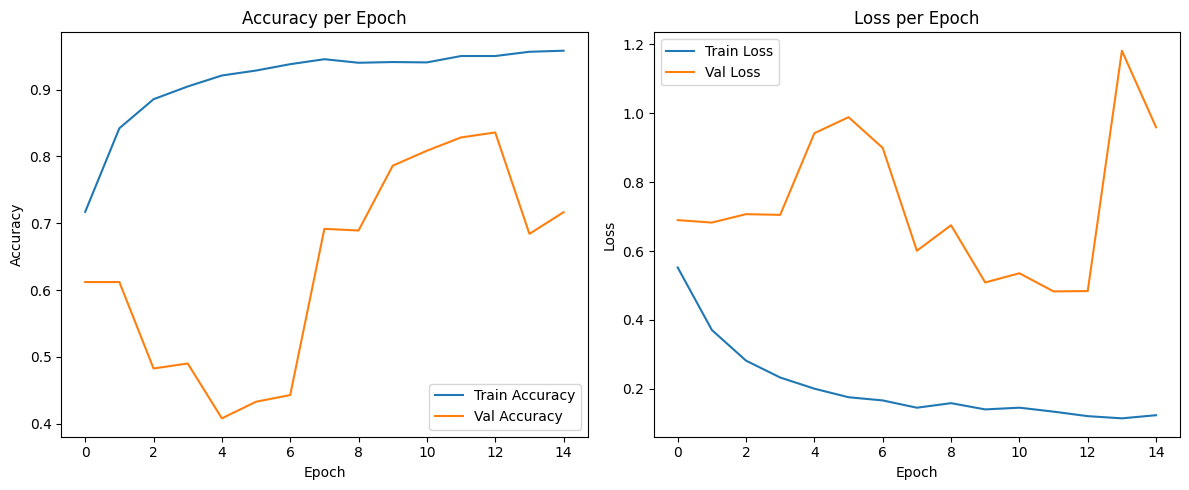

In [1]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import datetime

# ✅ Step 1: Download and set dataset path
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")
print("✅ Dataset downloaded at:", path)

train_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/train')
val_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/val')
test_dir = os.path.join(path, 'the_wildfire_dataset_2n_version/test')

# ✅ Step 2: GPU check
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("✅ GPU is available!")
else:
    print("⚠️ GPU not available.")

# ✅ Step 3: Dataset summary
classes = os.listdir(train_dir)
num_classes = len(classes)
print(f"Classes found: {classes}")

# ✅ Step 4: Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# ✅ Step 5: Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# ✅ Step 6: Base model + custom top
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ✅ Step 7: Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Step 8: Callbacks
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = f"wildfire_model_{timestamp}.h5"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# ✅ Step 9: Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint, lr_scheduler]
)

# ✅ Step 10: Save final model
model.save("final_wildfire_model.h5")
print("✅ Final model saved as 'final_wildfire_model.h5'")

# ✅ Step 11: Visualize history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()




Saving fire.jpg to fire (1).jpg
Saving test3.jpg to test3.jpg
Saving test2.jpg to test2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


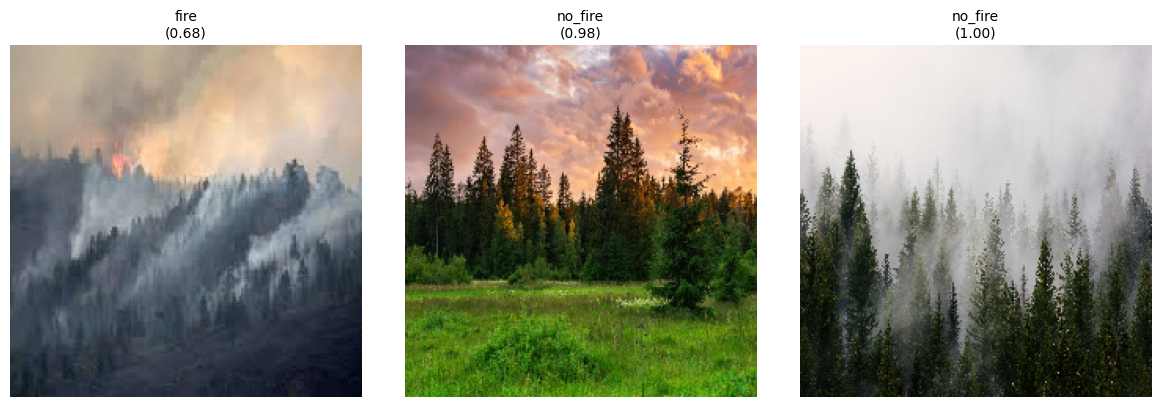

In [29]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Upload multiple images
uploaded = files.upload()

# Step 2: Load the trained model
model = load_model("final_wildfire_model.h5")

# Step 3: Define class names
class_names = ['fire', 'no_fire']

# Step 4: Predict and visualize horizontally with smaller size
def predict_and_display(uploaded_files):
    filenames = list(uploaded_files.keys())
    num_images = len(filenames)

    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 4))  # Smaller size, horizontal layout

    if num_images == 1:
        axes = [axes]  # Make it iterable

    for i, filename in enumerate(filenames):
        try:
            img = image.load_img(filename, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            predictions = model.predict(img_array)
            predicted_class = class_names[np.argmax(predictions)]
            confidence = np.max(predictions)

            # Plotting
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"{predicted_class}\n({confidence:.2f})", fontsize=10)
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

    plt.tight_layout()
    plt.show()

# Run it
predict_and_display(uploaded)


